In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 02/05/2023

    Code description :
    __________________
    Generates sparse object in various bases and recover it 
    by solving an inverse problem from rank-one projections.
    This file aims to numerically compare the link between the sparsity prior and reconstruction quality regarding the parameters setting.
    The numerical solver is Basis Pursuit (BP) or denoiser extensions from SPGL1 toolbox.
"""
import matplotlib.pyplot as plt
import numpy as np
from pyunlocbox import functions, solvers, acceleration
import pywt
import spgl1

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),3),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
set_plot_params() # Set the plot params
from utils_wavelet import *
from graphics import show_rec2D
from functions import corr_circ2

In [2]:
N = 32 # image sidelength
K = 30 # sparsity
Q = 110 # Number of cores
M = 300

"Fermat spiral"
diam_endo = np.sqrt(2)*(N/2) # Must be N for coherency between image resolution and cores distances
pos_sources = LE_cores (diam_endo, Q, sources_shape = 'fermat')
pos_inds = np.round((pos_sources+diam_endo/2)*N/diam_endo).astype(int) # convert sources positions to indices in R^(NxN) space.

"Define Om = {p_j - p_k, j,k \in [Q]}"
Om_x = np.subtract.outer(pos_inds[0,:], pos_inds[0,:]).astype(int)
Om_y = np.subtract.outer(pos_inds[1,:], pos_inds[1,:]).astype(int)

a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2) # Complex amplitude input to each core
B = np.zeros((N,N,M), dtype=complex)
B[pos_inds[0], pos_inds[1],:] = a_ij.T
B2 = corr_circ2(B.conj())

# Sparse in the spatial domain

$
    \begin{array}{ll}
    \boldsymbol{y} &= \left\{ (\boldsymbol{\beta}_m * \overline{\boldsymbol{\beta}}_m)^T \boldsymbol{F f} \right\}_{m=1}^M + \boldsymbol{n} \\
    &= \boldsymbol{\Beta Ff} + \boldsymbol{n}
    \end{array} 
$

where $*$ is the convolution operator, $\Beta$ is a $M \times N$ matrix whose lines are $\left\{ (\boldsymbol{\beta}_m * \overline{\boldsymbol{\beta}}_m) \right\}_{m=1}^M$ and $\boldsymbol{F}$ is the linear operator applying 1D Fourier transform. 


SPGL1
No. rows              :      300     
No. columns           :     1024

Initial tau           : 0.00e+00     
Two-norm of b         : 2.80e+01

Optimality tol        : 8.11e-03     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :     3000

iterr      Objective   Relative Gap  Rel Error      gnorm   stepg   nnz_x   nnz_g     tau

    0  2.7980000e+01  0.0000000e+00   1.00e+00  8.724e+01     0.0       0       0  8.9743649e+00
    1  2.2040456e+01  2.2716270e+00   1.00e+00  7.509e+01    -0.6      18       1               
    2  2.4472488e+01  1.5934778e+00   1.00e+00  5.388e+01    -1.2      18       1               
    3  2.2934335e+01  2.6646891e+00   1.00e+00  8.774e+01     0.0      16       1               
    4  2.2246099e+01  1.4757431e+00   1.00e+00  5.361e+01     0.0      18       1               
    5  2.1834767e+01  1.9549206e+00   1.00e+00  6.648e+01     0.0      19       1               
    6  2.1784310e+01  1.9013020e

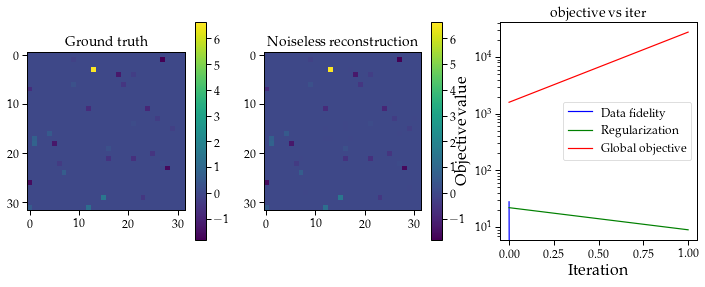

SNR: 57.11 dB


In [3]:
"Create the sample space"
pos_x = np.random.randint(0, high=N, size=K)
pos_y = np.random.randint(0, high=N, size=K)
f = np.zeros((N,N))
"Define the sparse object"
indices = np.random.permutation(np.arange(N**2))[:K] 
indices_x = indices//N
indices_y = indices%N
f[indices_y[:-1], indices_x[:-1]] = np.random.randn(K-1)
f[indices_y[-1], indices_x[-1]] = -np.sum(f)

SNR_target = 60
opt_tol =  np.linalg.norm(f)*10**(-SNR_target/20)
bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=opt_tol, verbosity=2) #, step_max=1e-1)
# bpdnalg = lambda A, b, sigma: spgl1.spg_bpdn(A, b, sigma)
# lasso = lambda A, b, tau: spgl1.spg_lasso(A, b, tau)


A_corr2 = Autocorr_model2(B2)
# A_corr2_r = Op2Real(A_corr2)
f2 = f.reshape(-1)
y_corr = A_corr2@f2
recovery = bpalg(A_corr2, y_corr)
x_corr = recovery[0].reshape((N,N))
rnorm2 = recovery[3]["rnorm2"]
xnorm1 = recovery[3]["xnorm1"]

# x_corr2 = bpdnalg(A_corr2_r, y_corr_r,1e-10)
# x_corr_lasso = lasso(A_corr2_r, y_corr_r, tau=K)

show_rec2D(f, x_corr, objective=[rnorm2, xnorm1], linewidth=1.2)

# # print('SNR: {:.2f} dB'.format(snr(f, x_corr2)) )
# # print('SNR: {:.2f} dB'.format(snr(f, x_corr_lasso)) )

# Sparse in Haar wavelets

$
    \begin{array}{ll}
    \boldsymbol{y} &= \left\{ (\boldsymbol{\beta}_m * \overline{\boldsymbol{\beta}}_m)^T \boldsymbol{F f} \right\}_{m=1}^M + \boldsymbol{n} \\
    &= \boldsymbol{\Beta F \Psi \alpha} + \boldsymbol{n}
    \end{array} 
$

where $*$ is the convolution operator, $\Beta$ is a $M \times N$ matrix whose lines are $\left\{ (\boldsymbol{\beta}_m * \overline{\boldsymbol{\beta}}_m) \right\}_{m=1}^M$, $\boldsymbol{F}$ is the linear operator applying 1D Fourier transform and $\boldsymbol{\Psi}$ is the Haar Wavelet transform written in matrix format with the associated wavelet coefficients $\boldsymbol{\alpha}$. 


SPGL1
No. rows              :     3000     
No. columns           :     1024

Initial tau           : 0.00e+00     
Two-norm of b         : 5.36e+02

Optimality tol        : 2.50e-03     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :    30000

iterr      Objective   Relative Gap  Rel Error      gnorm   stepg   nnz_x   nnz_g     tau

    0  5.3606122e+02  0.0000000e+00   1.00e+00  7.540e+04     0.0       0       0  3.8112085e+00
    1  4.0209817e+02  1.9969279e+00   1.00e+00  5.648e+04    -0.6       1       1               
    2  3.1512983e+01  4.9450531e-03   1.00e+00  1.299e+02     0.0       1       1               
    3  3.1496277e+01  9.7666977e-02   1.00e+00  3.187e+01     0.0       1       0               
    4  3.1492394e+01  8.7628539e-02   1.00e+00  3.185e+01     0.0       1       0               
    5  3.1496524e+01  3.6791783e-03   1.00e+00  1.241e+02    -1.5       1       1               
    6  3.1489740e+01  2.0280346e

Linesearch failed with error 1. Damping max BB scaling to 10000.0


  244  3.5609513e-01  1.8207982e+03   3.56e-01  1.543e+01    -3.0     335       1  1.0640867e+02


Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0


  246  3.5609513e-01  1.8209250e+03   3.56e-01  1.543e+01    -3.0     335       1  1.0641689e+02


Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0


  248  3.5609513e-01  1.8210518e+03   3.56e-01  1.543e+01    -3.0     335       1  1.0642511e+02


Linesearch failed with error 1. Damping max BB scaling to 0.1


  250  1.6137134e-01  1.5979828e+03   1.61e-01  1.450e+01    -3.0     335       0               
  252  1.2430058e-01  4.8881622e+00   1.24e-01  4.650e-02     0.0     335       5  1.0675736e+02
  260  1.1470958e-01  4.0864455e+02   1.15e-01  3.697e+00    -0.9     335       0               
  263  1.1165385e-01  4.4473790e+00   1.12e-01  4.253e-02     0.0     335       5  1.0705050e+02
  270  1.0434150e-01  2.4040589e+02   1.04e-01  2.169e+00    -0.9     335       0               
  273  1.0318713e-01  4.0778486e+00   1.03e-01  3.871e-02     0.0     335       5  1.0732557e+02
  278  9.7628351e-02  3.8735700e+00   9.76e-02  3.675e-02     0.0     335       5  1.0758492e+02
  280  9.2893853e-02  2.1563091e+02   9.29e-02  1.937e+00    -0.3     335       0               
  290  8.7164906e-02  1.5763267e+02   8.72e-02  1.416e+00     0.0     335       0               
  293  8.6571717e-02  3.3871882e+00   8.66e-02  3.185e-02     0.0     335       9  1.0782021e+02
  298  8.0954234e-02  3.257345

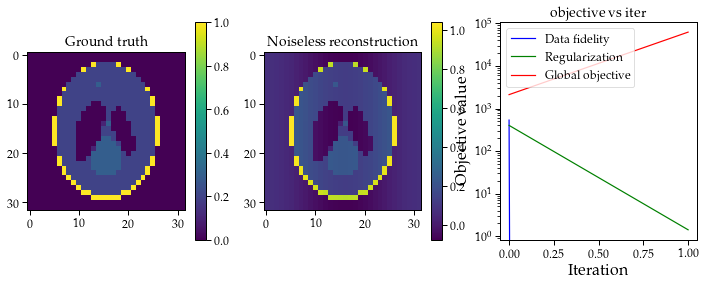

SNR: 13.16 dB


In [4]:
N = 32 # image sidelength
# K = 30 # sparsity
Q = 140 # Number of cores
M = 3000

model_choice = 'corr' # 'ROP' 
object_choice = 'phantom' # 'random'


"Fermat spiral"
diam_endo = np.sqrt(2)*(N/2) # Must be N for coherency between image resolution and cores distances
pos_sources = LE_cores (diam_endo, Q, sources_shape = 'fermat')
pos_inds = np.round((pos_sources+diam_endo/2)*N/diam_endo).astype(int) # convert sources positions to indices in R^(NxN) space.

"Define Om = {p_j - p_k, j,k \in [Q]}"
Om_x = np.subtract.outer(pos_inds[0,:], pos_inds[0,:]).astype(int)
Om_y = np.subtract.outer(pos_inds[1,:], pos_inds[1,:]).astype(int)

a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2) # Complex amplitude input to each core
B = np.zeros((N,N,M), dtype=complex)
B[pos_inds[0], pos_inds[1],:] = a_ij.T
B2 = corr_circ2(B.conj())

if (model_choice == 'corr'):
    A_mod = Autocorr_model2(B2, wt='haar')
else:
    A_mod = ROP_model2(Om_x, Om_y, a_ij, N, wt='haar')

#________
if (object_choice == 'random'):
    pos_x = np.random.randint(0, high=N, size=K)
    pos_y = np.random.randint(0, high=N, size=K)
    alpha = np.zeros((N,N))
    "Define the sparse object"
    alpha[pos_y[:-1], pos_x[:-1]] = np.random.randn(K-1)
    alpha[pos_y[-1], pos_x[-1]] = -np.sum(alpha)
    alpha2 = alpha.reshape(-1)
    f_wav = A_mod.wavT2(alpha2)
else:
    from shepp_logan import phantom
    f_wav = phantom(N)
    alpha2 = A_mod.wav2(f_wav)
#________

SNR_target = 70
opt_tol =  np.linalg.norm(alpha2)*10**(-SNR_target/20)
bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=opt_tol, verbosity=2) #, step_max=1e-1)

y = A_mod@alpha2
recovery = bpalg(A_mod, y)
x_rec = A_mod.wavT2(recovery[0])
rnorm2 = recovery[3]["rnorm2"]
xnorm1 = recovery[3]["xnorm1"]

# x_rec2 = bpdnalg(A_mod, y,1e-10)
# x_rec_lasso = lasso(A_mod, y, tau=K)

show_rec2D(f_wav, x_rec, objective=[rnorm2, xnorm1], linewidth=1.2)

# print('SNR: {:.2f} dB'.format(snr(f_wav, A_mod.wavT2(x_rec))) )
# # print('SNR: {:.2f} dB'.format(snr(f, x_rec2)) )
# # print('SNR: {:.2f} dB'.format(snr(f, x_rec_lasso)) )

# Sparse in TV - Piecewise constant

Solve 
$
    \hat f = \argmin_f~\frac{1}{2} \left\lVert \boldsymbol y - \boldsymbol{\mathcal A \mathcal{I}_\Omega[wf]} \right\rVert_2^2 + \lambda \left\lVert f \right\rVert_{\text{TV}}
$

In [5]:
"Create the sample space"
pos_x = np.sort(np.random.randint(0, high=N, size=K))
pos_y = np.sort(np.random.randint(0, high=N, size=K))
f = np.zeros((N,N))
"Define the sparse object"
K = 4
for i in range(K-1):
    f[pos_x[i]:, pos_y[i]:] += np.random.randint(-5, high=5)

"ROP model"
A_mod = ROP_model2(Om_x, Om_y, a_ij, N, wt=None)
A_op = lambda Xin: A_mod._matvec(Xin)
At_op = lambda Xin: A_mod._rmatvec(Xin)
nu_rop1 = eval_nu(np.random.randn(N,N), A_op, At_op, nb_iter=50)*1.01

y = A_op(f)

f1 = functions.norm_tv(maxit=80, dim=2)
f2 = functions.norm_l2(y=y, A=A_op, At=At_op, nu=nu_rop1)
solver = solvers.forward_backward(step=0.5/nu_rop1)
x0 = At_op(y)
ret1 = solvers.solve([f1, f2], x0, solver, rtol=1e-7, maxit=2000)

show_rec2D(f, ret1['sol'], objective=ret1['objective'], linewidth=1.2)

KeyboardInterrupt: 